In [77]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler

In [78]:
import torch
import torch.nn as nn
import sys
import os
from utils import create_sliding_windows, SequentialDeepONetDataset
from torch.utils.data import DataLoader

src_path = os.path.abspath(os.path.join(os.getcwd(), 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils import create_sliding_windows, SequentialDeepONetDataset
from s_deeponet import SequentialDeepONet

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Dataset

In [80]:
# Target scaler values [min, max]
target_min = 0.02640343
target_max = 0.03839979

target_scaler = [target_min, target_max]

# trunk
trunk = np.load('data/grid_points.npy')

print(trunk[:,0].min(), trunk[:,0].max())
print(trunk[:,1].min(), trunk[:,1].max())

# Normalize trunk input
trunk[:, 0] = (trunk[:, 0] - np.min(trunk[:, 0])) / (np.max(trunk[:, 0]) - np.min(trunk[:, 0]))
trunk[:, 1] = (trunk[:, 1] - np.min(trunk[:, 1])) / (np.max(trunk[:, 1]) - np.min(trunk[:, 1]))

-90.0 90.0
-180.0 180.0


In [81]:
# Load the sensor data
test_input = np.load('data/test_data.npz')['test_input']
test_target = np.load('data/test_data.npz')['test_target']

In [82]:
# Generate sequences for the testing set
test_input_seq, test_target_seq = create_sliding_windows(test_input, test_target, window_size=7)

In [83]:
test_dataset = SequentialDeepONetDataset(test_input_seq, trunk, test_target_seq)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# model initialization

In [84]:
def init_model():
    dim = 128
    model = SequentialDeepONet(
        branch_type='lstm',
        branch_input_size=12,
        branch_hidden_size=128,
        branch_num_layers=4,
        branch_output_size=dim,
        trunk_architecture=[2, 128, 128, dim],
        num_outputs=1,
        use_transform=False,
        activation_fn=nn.ReLU,
    )
    return model

In [85]:
# pre-trained model path
save_path = os.path.join('single_branch', 'lstm_window_7.pth')

model = init_model()
model.load_state_dict(torch.load(save_path, map_location='cpu'))

model.eval()

SequentialDeepONet(
  (branch_net): LSTM(
    (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)

In [88]:
all_outputs = []
all_targets = []

model.eval()
with torch.no_grad():
    for branch_batch, trunk_batch, target_batch in test_loader:
        branch_batch, trunk_batch, target_batch = (
            branch_batch.to(device),
            trunk_batch.to(device),
            target_batch.to(device),
        )
        output = model(branch_batch, trunk_batch)
        
        all_outputs.append(output.cpu())
        all_targets.append(target_batch.cpu())

# After loop:
outputs = torch.cat(all_outputs, dim=0)  # [N_test, output_dim]
targets = torch.cat(all_targets, dim=0)  # [N_test, output_dim]


In [89]:
def convert2dim(dose_array):
    # laod the grid_array
    grid_array = np.load('data/grid_points.npy')

    # Sort grid_array by latitude first (column 0), then by longitude (column 1)
    sorted_indices = np.lexsort((grid_array[:, 1], grid_array[:, 0]))
    sorted_grid_array = grid_array[sorted_indices]
    sorted_dose_array = dose_array[sorted_indices]
    
    # Extract unique latitude and longitude values from the sorted grid array
    latitudes = np.unique(sorted_grid_array[:, 0])  # Extract unique latitude values (y-axis)
    longitudes = np.unique(sorted_grid_array[:, 1])  # Extract unique longitude values (x-axis)

    # Create a meshgrid with (longitude, latitude) to match the correct order
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    # Ensure the sorted dose_array is reshaped correctly to match the meshgrid dimensions
    z = sorted_dose_array.reshape(len(latitudes), len(longitudes))
    
    return lon_grid, lat_grid, z

In [90]:
# get and transform
# convert the preds and targets to 2D
preds_2d = []
targets_2d = []
for i in range(len(outputs)):
    pred_2d = convert2dim(outputs[i])
    target_2d = convert2dim(targets[i])
    preds_2d.append(pred_2d)
    targets_2d.append(target_2d)
    
# convert to numpy array
preds_2d = np.array(preds_2d)
targets_2d = np.array(targets_2d)

In [100]:
preds_2d.shape

(359, 3, 181, 361)

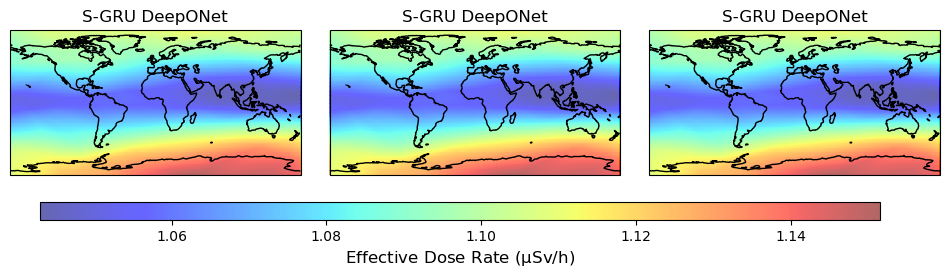

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

# Create a "lighter" version of the jet colormap
jet_cmap = plt.cm.jet
jet_cmap_alpha = jet_cmap(np.arange(jet_cmap.N))
jet_cmap_alpha[:, -1] = 0.6  # Adjust transparency
jet = ListedColormap(jet_cmap_alpha)

fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Reduce space between subplots

# Store the last colormap object for colorbar reference
im_pred, im_error = None, None


# Loop through the three selected samples (best, 90th percentile, worst)
for i in range(3):

    ax = axes[i]
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.BORDERS, linestyle='')
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    data = preds_2d[0][2]
    title = f'S-GRU DeepONet'
    im_pred = ax.pcolormesh(preds_2d[0][0], preds_2d[0][1], data,
                                cmap=jet,)

    ax.set_title(title, fontsize=12)

cbar_ax = fig.add_axes([0.15, 0.3, 0.70, 0.03])  # x, y, width, height
cbar = fig.colorbar(im_pred, cax=cbar_ax, orientation='horizontal')S
cbar.set_label(r"Effective Dose Rate ($\rm \mu Sv/h$)", fontsize=12)


plt.show()